In [9]:
from pathlib import Path
import numpy as np
import soundfile
import matplotlib.pyplot as plt
import librosa
from pprint import pprint
import scipy.ndimage
import scipy.signal
import logging
import itertools
import scipy.sparse
import datetime
import os
import pickle
import time

from unmixdb import UnmixDB
from abcdj import ABCDJ
import activation_learner, carve, plot, param_estimator, modular_nmf
from common import dense_to_sparse, sparse_to_dense

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [10]:
FS = 22050
# T = np.linspace(0, 10, 10 * FS)
# inputs = [
# 0.01 * np.sin(2 * np.pi * 200 * T**2),
# np.sin(2 * np.pi * 200 * (T)**2) * np.linspace(0, 1, len(T)),
# ]
input_paths = ["linear-mix-1.wav", "linear-mix-2.wav", "linear-mix.wav"]
inputs = [librosa.load(path, sr=FS)[0] for path in input_paths]

FS = 22050
HOP_SIZES = [2.0, 0.1]
OVERLAP_FACTOR = 1
CARVE_THRESHOLD_DB = -60
NMELS = 256
DIVERGENCE = modular_nmf.BetaDivergence(0)
PENALTIES = [
    (modular_nmf.SmoothDiago(), 216),
    (modular_nmf.L1(), 23),
    (modular_nmf.L2(), 823),
    (modular_nmf.SmoothGain(), 23),
]
POSTPROCESSORS = [
]
PP_STRENGTH = 0
LOW_POWER_FACTOR = 2e-2
# stop conditions
DLOSS_MIN = 1e-7
LOSS_MIN = -np.inf
ITER_MAX = 3000
## other stuff
# logging
PLOT_NMF_EVERY = 600
LOG_NMF_EVERY = 100

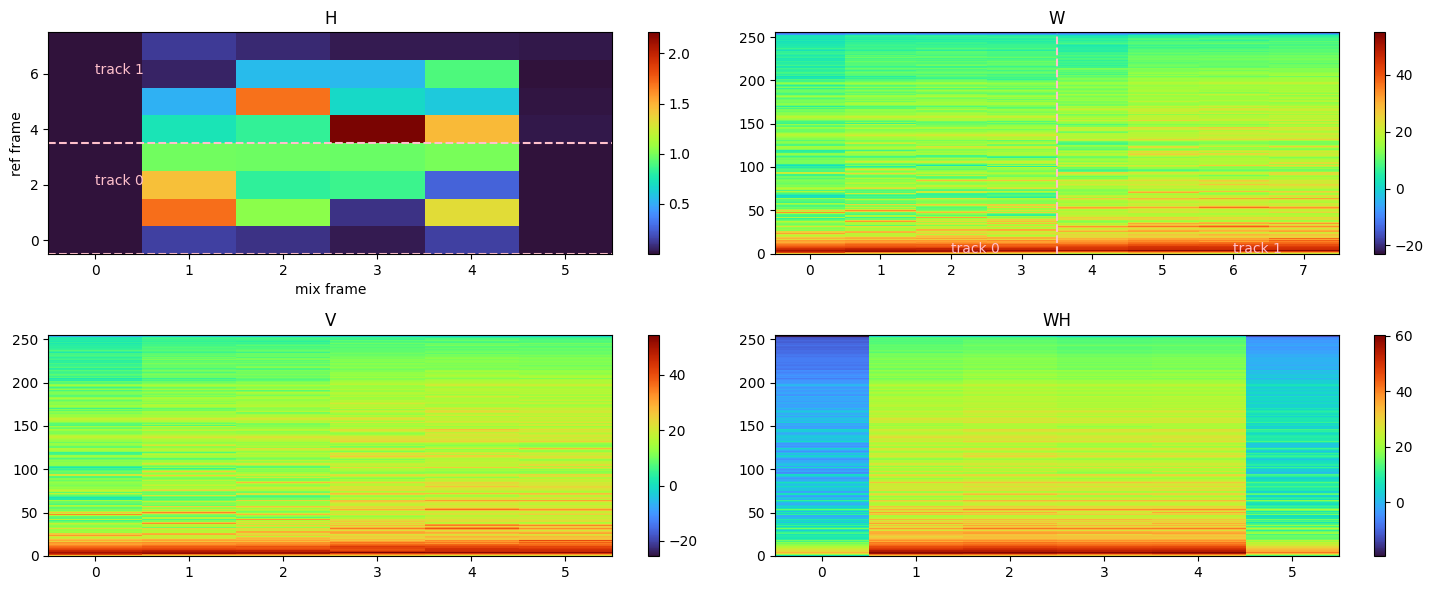

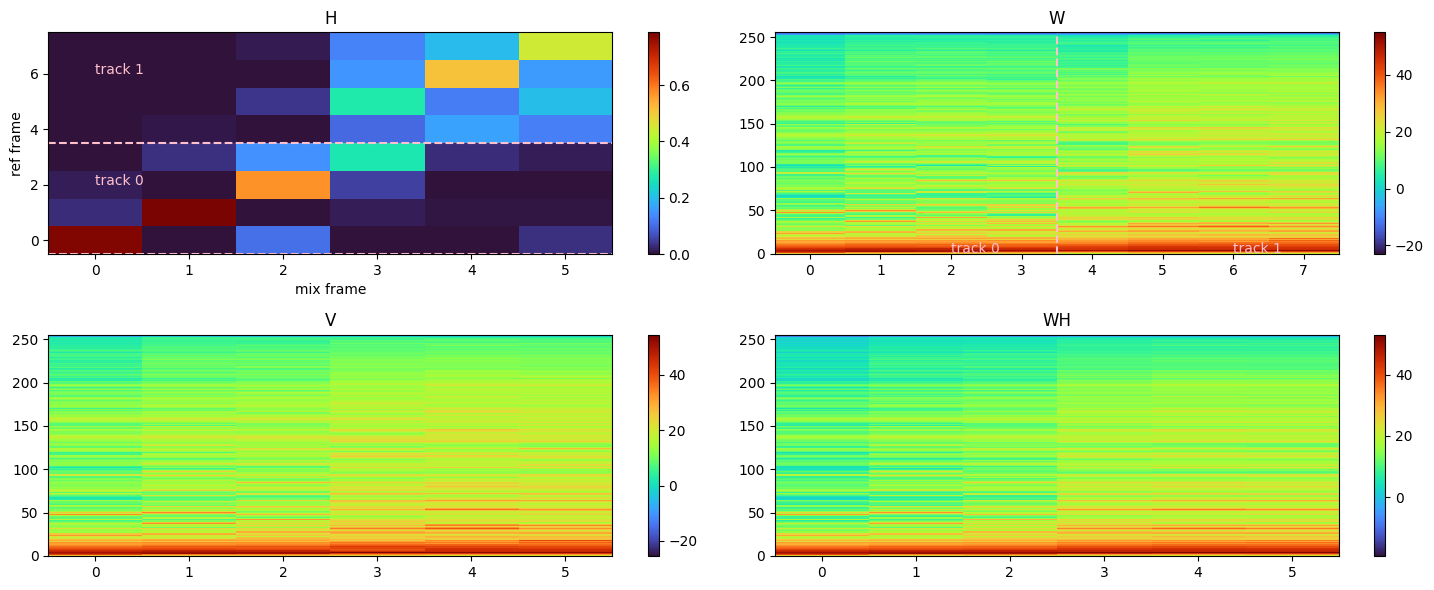

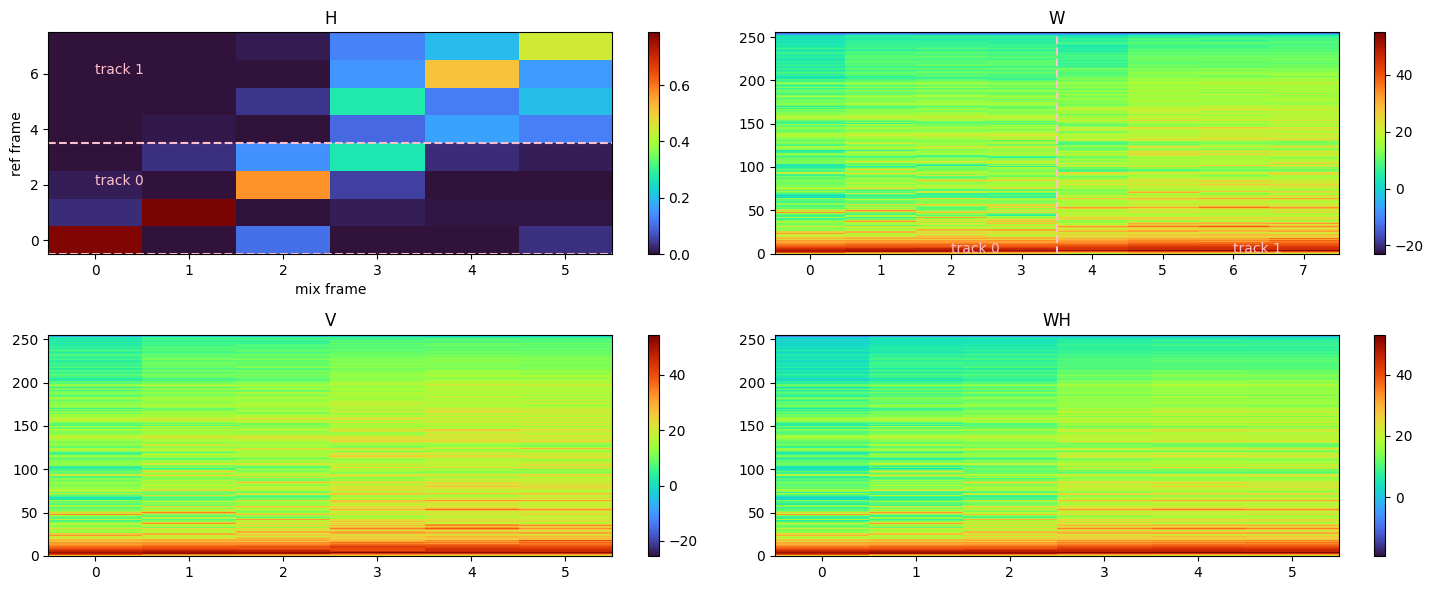

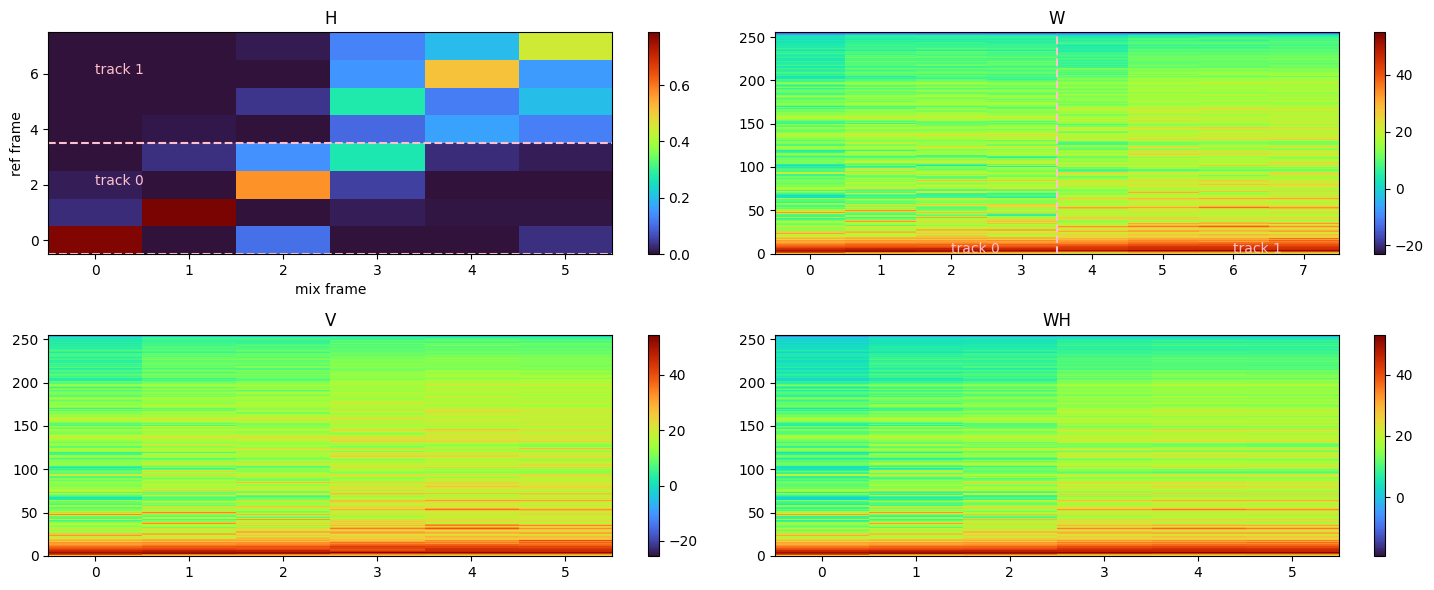

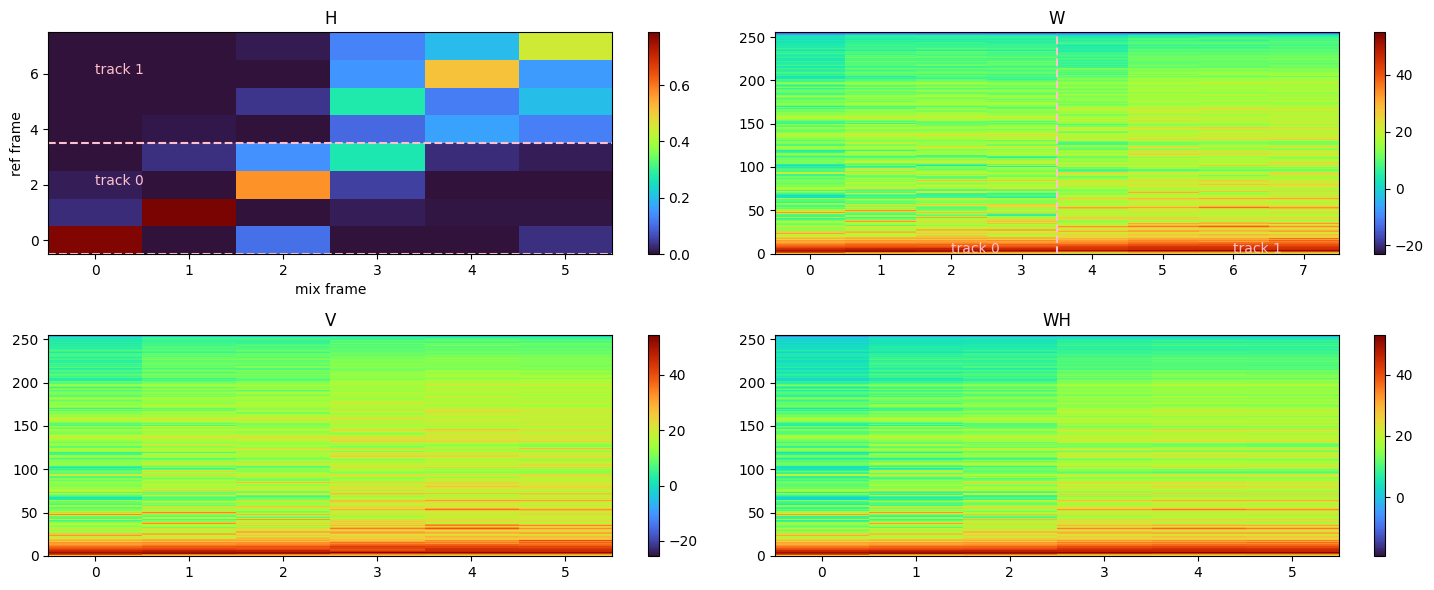

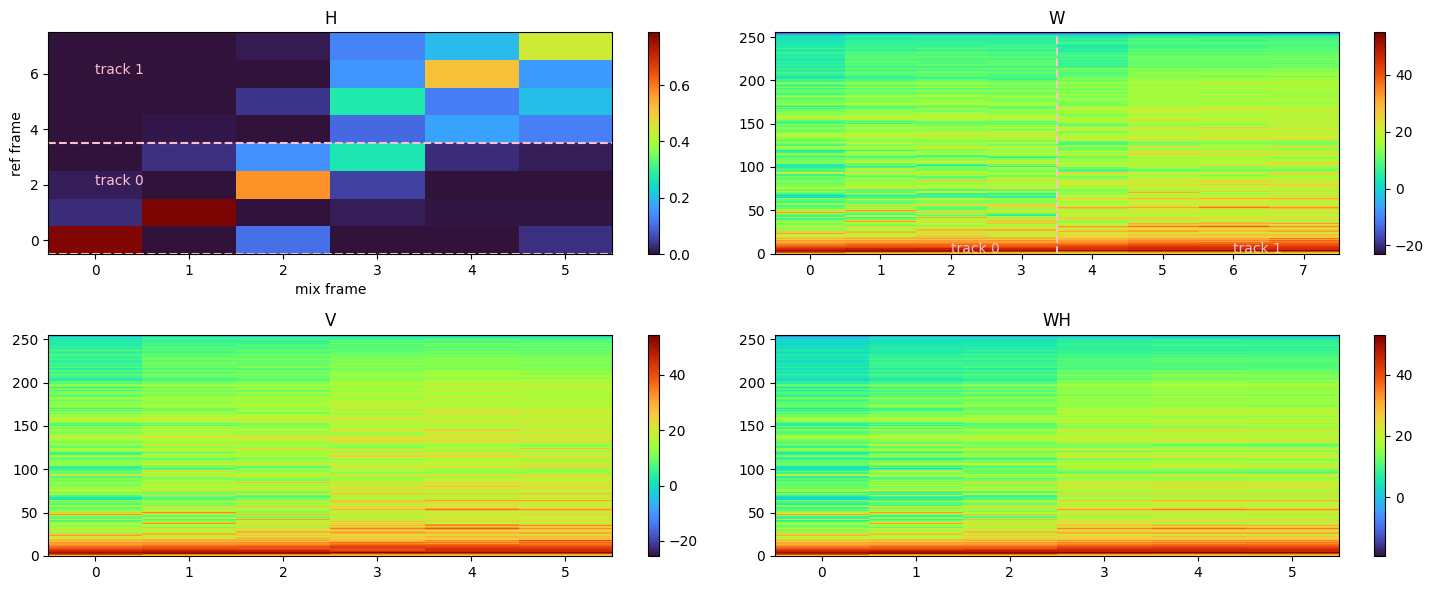

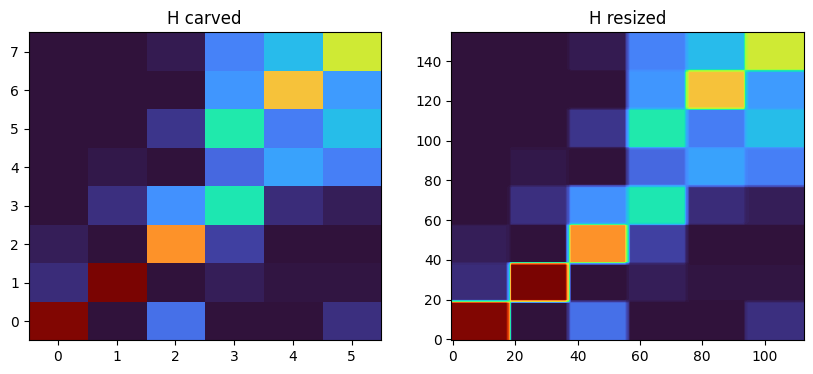

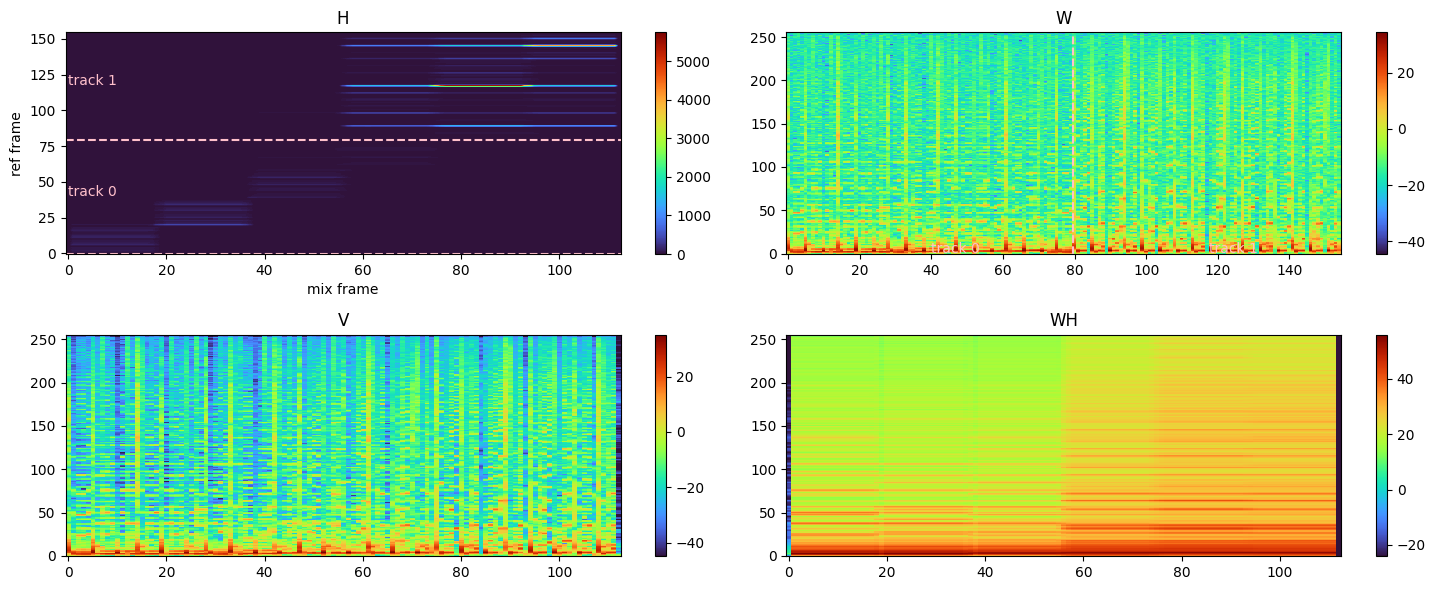

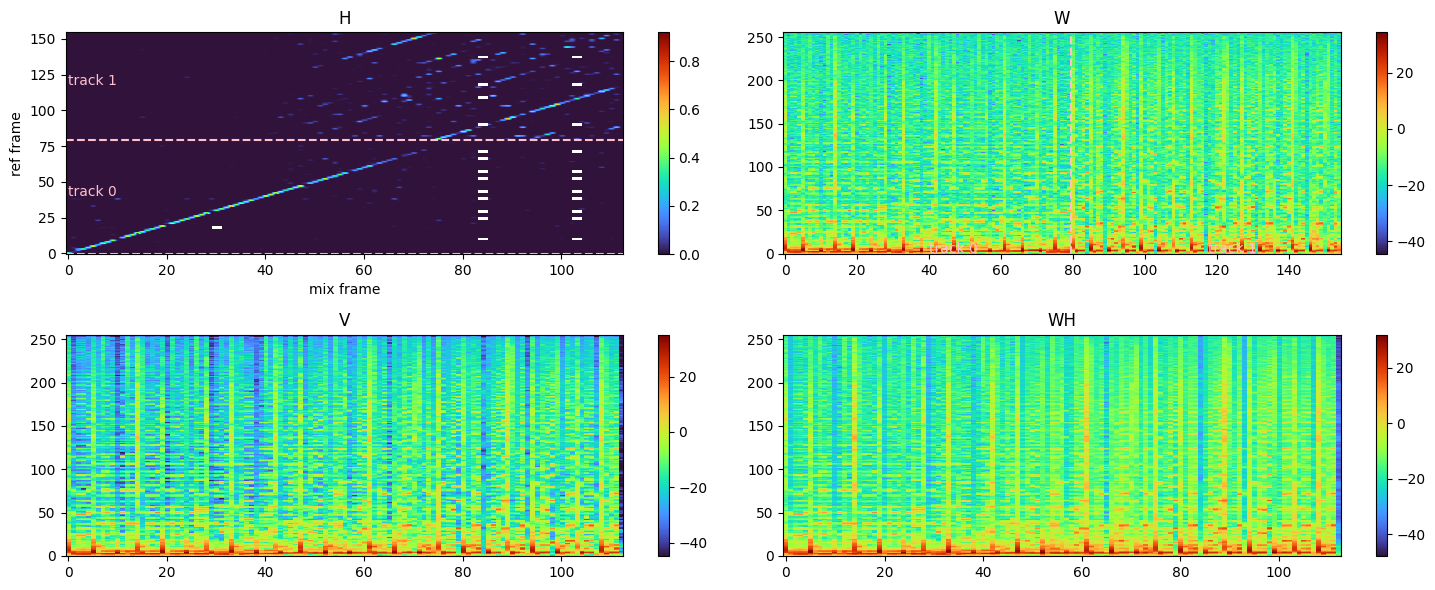

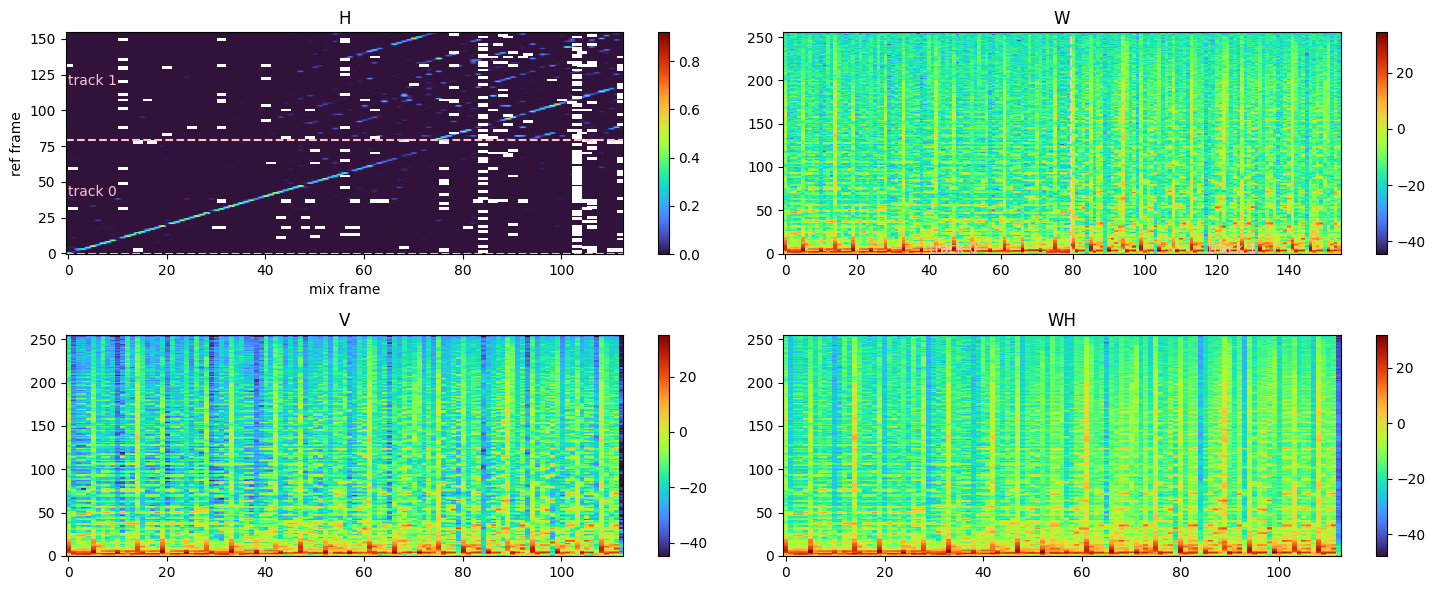

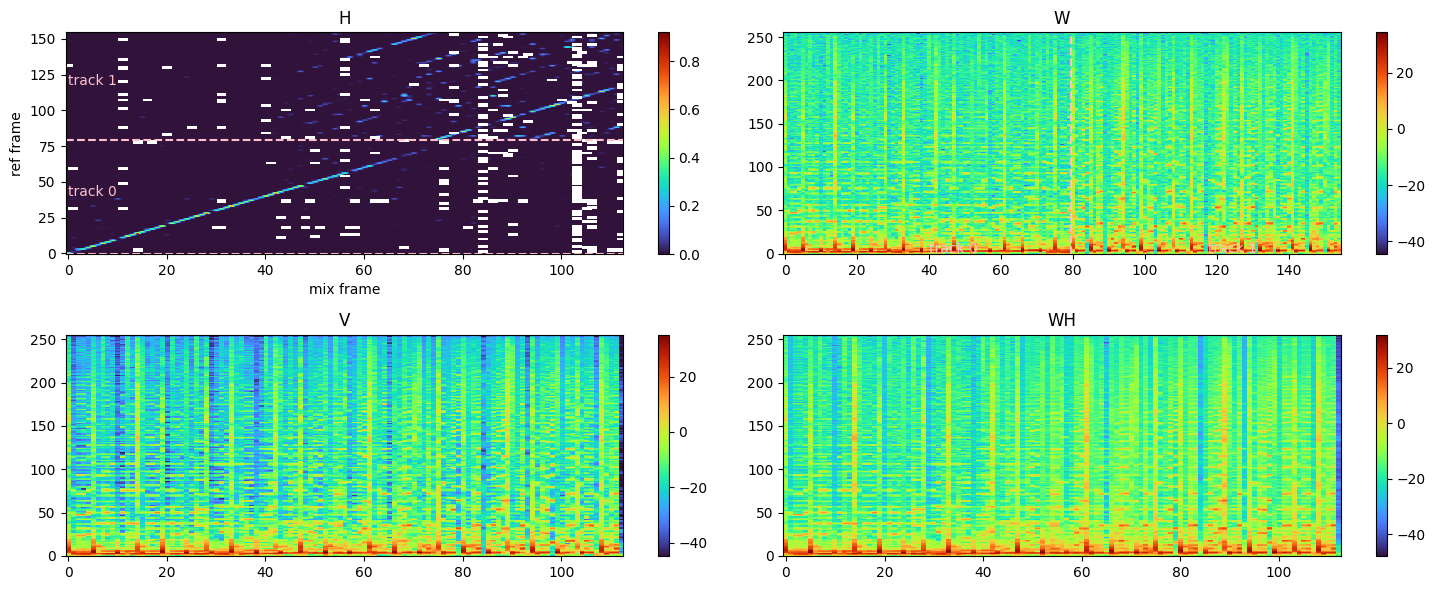

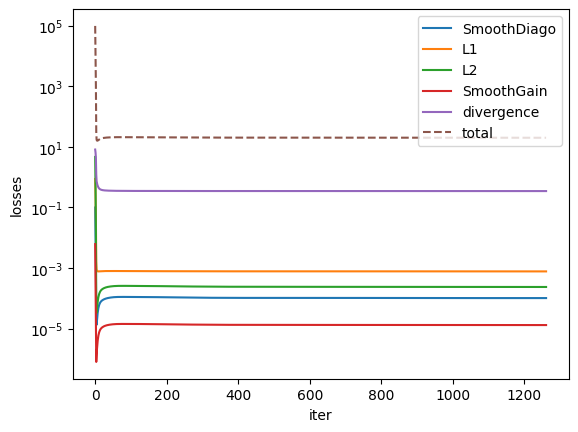

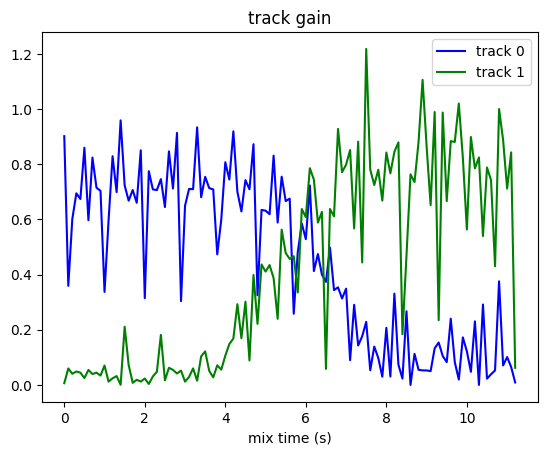

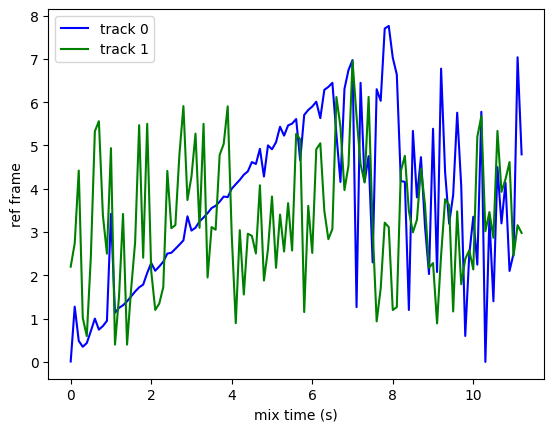

In [11]:
# multi pass NMF
previous_H = None
previous_split_idx = None
for hop_size in HOP_SIZES:
    win_size = OVERLAP_FACTOR * hop_size
    logger.info(f"Starting round with {hop_size=}s, {win_size=}s")

    learner = activation_learner.ActivationLearner(
        inputs,
        fs=FS,
        n_mels=NMELS,
        win_size=win_size,
        hop_size=hop_size,
        divergence=DIVERGENCE,
        penalties=PENALTIES,
        postprocessors=POSTPROCESSORS,
        low_power_factor=LOW_POWER_FACTOR,
    )

    # carve and resize H from previous round
    if previous_H is not None:
        H_carved = carve.carve(previous_H, previous_split_idx, CARVE_THRESHOLD_DB)
        H_carved_resized = carve.resize_cv_area(H_carved, learner.H.shape)
        plot.plot_carve_resize(H_carved, H_carved_resized)
        plt.show()

        learner._H = dense_to_sparse(H_carved_resized)

    # iterate
    logger.info("Running NMF")
    last_loss = np.inf
    loss_history = []
    for i in itertools.count():
        loss, loss_components = learner.iterate(PP_STRENGTH)
        dloss = abs(last_loss - loss)
        last_loss = loss
        loss_history.append(loss_components)

        if i % LOG_NMF_EVERY == 0:
            logger.info(f"NMF iteration={i} loss={loss:.2e} dloss={dloss:.2e}")
        if dloss < DLOSS_MIN or np.sum(loss) < LOSS_MIN or i > ITER_MAX:
            logger.info(f"Stopped at NMF iteration={i} loss={loss} dloss={dloss}")
            break
        if i % PLOT_NMF_EVERY == 0:
            plot.plot_nmf(learner)
            plt.show()

    previous_H = learner.H
    previous_split_idx = learner.split_idx

# plot NMF
plot.plot_nmf(learner)
plt.show()

# plot loss history
plot.plot_loss_history(loss_history)
plt.show()

# get ground truth
tau = np.arange(0, learner.V.shape[1]) * hop_size

GAIN_ESTOR = param_estimator.GainEstimator.SUM
WARP_ESTOR = param_estimator.WarpEstimator.CENTER_OF_MASS

# estimate gain
logger.info(f"Estimating gain with method {GAIN_ESTOR}")
est_gain = GAIN_ESTOR.value(learner)
plot.plot_gain(tau, est_gain)
plt.show()

# estimate warp
logger.info(f"Estimating warp with method {WARP_ESTOR}")
est_warp = WARP_ESTOR.value(learner, hop_size)
fig = plt.figure()
plot.plot_warp(tau, est_warp)
plt.show()